In [389]:
import numpy as np
import matplotlib.pyplot as plt

class RBFnn:
    def __init__(self, input_size, neuron_num, output_size):
        self.L = output_size
        self.N = input_size
        self.M = neuron_num
        self.mu = np.random.random([input_size, neuron_num])
        self.sigma = np.ones([input_size, neuron_num])
        self.W = np.random.random([neuron_num, output_size])
        self.bias = np.zeros([1, output_size])

    def forward(self, x):

        # print(f'expandx={np.expand_dims(np.expand_dims(x,-1),0)}')
        # print(f'x={x.shape}')
        # print(f'expandmu={np.expand_dims(np.expand_dims(self.mu,0),1)}')
        # print(f'mu={self.mu.shape}')
        # print(f'expandsigma={np.expand_dims(np.expand_dims(self.sigma,0),1)}')
        # print(f'sigma={self.sigma.shape}')

        phi = np.exp(-((np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0))**2)
        phi = phi.prod(1)
        self.phi = phi
        y_hat = phi @ self.W + self.bias
        return(y_hat)
    def grad(self, x, e):
        error1 = e 
        error = (np.expand_dims(self.W, 0)*np.expand_dims(error1, 1)).mean(-1)  # sample * neuron_num

        grad_W = (np.expand_dims(self.phi,-1)*np.expand_dims(error1, 1)).mean(0)

        grad_mu = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_mu = grad_mu.mean(0)

        grad_sigma = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))**2/np.expand_dims(self.sigma,0)**3)*np.expand_dims(error, 1)
        grad_sigma = grad_sigma.mean(0)

        grad_bias = error1.mean(-1).mean(0)#*0

        grad_for_previous = -(np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_for_previous = grad_for_previous.mean(-1)
        return(grad_W, grad_mu, grad_sigma, grad_bias, grad_for_previous)
    def Train(self, x, e, learning_rate = 0.01):#e, Ac
        grad_W, grad_mu, grad_sigma, grad_bias, grad_for_previous = self.grad(x, e)#e, Ac
        self.W -= learning_rate * grad_W
        self.mu -= learning_rate * grad_mu
        self.sigma -= learning_rate * grad_sigma
        self.bias -= learning_rate * grad_bias
        # return grad_for_previous
            

In [390]:
# System parameters 
M = 1 #kg
g = 9.81 
L = 1 #m
I = 0.5
J = 0.008
k = 0.3

In [391]:
# Define system ODE: dx/dt = f(x,u)
#x = [q1, q2, q1_dot, q2_dot]
import numpy as np
from scipy.integrate import odeint

def sys_ode(x,u):

    dx_1 = x[0][2] 
    dx_2 = x[0][3]
    dx_3 = -M*g*L*np.sin(x[0][0])/I - k/I * (x[0][0]-x[0][1])
    dx_4 = -k/J * (x[0][1]-x[0][0]) + 1/J * u 
    dx = np.array([dx_1, dx_2, dx_3, dx_4]).reshape([1,-1])
    
    return dx

In [392]:
class Single_Link_Flexible_Joint:
    def __init__(self, dt = 0.001):
        self.y = np.array([[0], [0], [0], [0]]).T
        self.Ac = -20*np.eye(4)
        self.dt = dt
        self.t = np.linspace(0, 10, int((10-0)/dt))
        self.xd = np.array([[.2*np.sin(4*np.pi*self.t/3)], [np.sin(4*np.pi*(self.t)/3)], [np.sin(4*np.pi*self.t/3)], [2*np.cos(4*np.pi*(self.t)/3)]]).T
        self.x = np.array([[.1],[.2],[.3],[.4]]).T
    def step(self, u):
        self.x_dot = sys_ode(self.x, u)
        self.x += self.x_dot * self.dt
        self.y = self.x#[:,0].reshape([1,-1])

In [393]:
controller = RBFnn(input_size = 8, neuron_num = 1, output_size = 1)
observer = RBFnn(input_size = 5, neuron_num = 1, output_size = 4)

plant = Single_Link_Flexible_Joint()
history = {'y': [], 'y_observer': [], 'u':[]}
for i in range(len(plant.t)):
    # print(f'y[0]={np.array(plant.y[0])}')
    # print(f'xd[i]={plant.xd[i]}')
    input_ = np.hstack([plant.y[0], plant.xd[i][0]]).reshape([1,-1])
    u = controller.forward(input_)
    obs_input = np.hstack((np.copy(plant.y), u))
    y_hat = observer.forward(obs_input)
    plant.step(u[0,0])

    ### Obs : RBF , Controller : RBF
    Loss_derivative_controller = (y_hat - plant.xd[i]).reshape([1,-1])
    loss_derivative_observer = y_hat - plant.y
    _, _, _, _, grad_for_previous = observer.grad(obs_input, Loss_derivative_controller + loss_derivative_observer)# + loss_derivative_observer*.1
    controller.Train(input_, grad_for_previous[:,plant.x.shape[1]:] + .03*u, learning_rate=.1)

    observer.Train(obs_input, loss_derivative_observer + Loss_derivative_controller, learning_rate=.0008)

    
    history['y'].append(plant.y[0,0])
    history['y_observer'] .append(y_hat[0,0])
    history['u'].append(u[0,0])

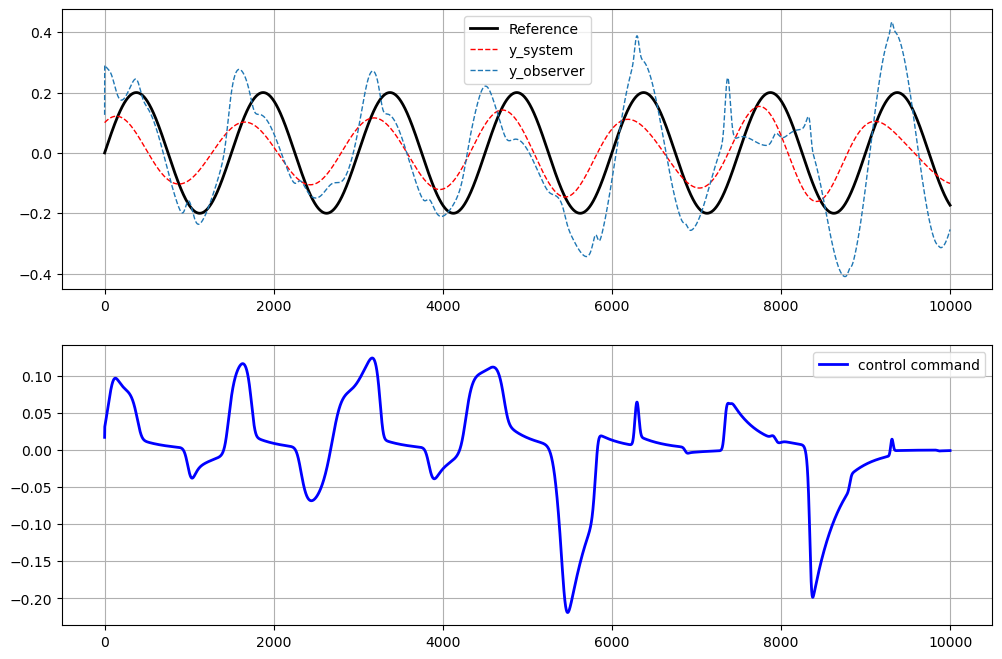

In [394]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(plant.xd[:,0,0], 'k-', linewidth = 2)
plt.plot(history['y'], 'r--', linewidth = 1)
plt.plot(history['y_observer'], '--', linewidth = 1)
plt.legend(['Reference', 'y_system', 'y_observer'])
plt.grid('on')

plt.subplot(2,1,2)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')
plt.legend()

In [395]:
plant.y.shape

(1, 4)

In [396]:
plant.x.shape

(1, 4)